## Import required packages

- numpy is the fundamental package for scientific computing with Python.
- matplotlib is a library to plot graphs in Python.
- seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- scipy is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
- statistics provides functions for calculating mathematical statistics of numeric (Real-valued) data.
- itertools is function creating iterators for efficient looping
- sklearn is a machine learning library for Python language.
- boruta is feature wrapping technique based on random forest.
- SMOTE and ADASYN is the oversampling technique in the library imblearn.over_sampling


- np.random.seed(42) is used to keep all the random function calls consistent.

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit   
from itertools import product
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.model_selection import cross_val_score

np.random.seed(42)       
#from fancyimpute import KNN

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Define functions

In [2]:
# Function to remove columns having more than 55% null values

# start from the 0 column and count the nA of that column. 
# If the ratio of NA is higher than 55%, we delete this column.
# Otherwise i plus 1 to the next column. Use While loop to iterate until the last column

def delete_na(dataframe,threshold = 0.55):   # threshold = 0.55 as default value
    i = 0
    while i < len(dataframe.columns):    
        if dataframe.iloc[:,i].isnull().sum()/len(dataframe) > threshold:
            dataframe.drop(dataframe.columns[[i]], axis = 1,inplace = True)
        else:
            i = i+1

In [4]:
# Function to remove features with low variance

# set a threshold for standard deviation of the features. We remove about 25% variables correspondingly std of 0.003.
def remove_std(dataframe, threshold = 0.003): # threshold = 0.003 as default value
    i = 0
    while i < len(dataframe.columns):    
        if dataframe.iloc[:,i].std() < threshold:      
            dataframe.drop(dataframe.columns[[i]], axis = 1,inplace = True)
        else:
            i = i+1

In [5]:
# Define a function to calculate the z-scores of the dataframe

def z_score(df):
    df.columns = [X + "_zscore" for X in df.columns.tolist()]
    return ((df - df.mean())/df.std(ddof=0))

In [6]:
# Defining a function to replace outliers with nan values. 

def outlier_impute(dataframe, threshold=3):   # threshold =3 is default value
    for cols in dataframe.columns:
        dataframe.loc[((dataframe[cols]>threshold) | (dataframe[cols]<-threshold)),cols] = np.nan
    return dataframe

In [7]:
# define a function to replace Nan with mean of the column. 

# For loop will iterate from the first feature to the last feature.
def na_mean_imputer(dataframe):
    for i in range(len(dataframe.columns)): 
        mean = dataframe.iloc[:,i].mean()
        dataframe.iloc[:,i].fillna(mean, inplace=True)
    return dataframe

In [8]:
# define a function to visualize the confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##  Step 1: Get data from online source

In [9]:
# read the data online
secom_get = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data')
secom_label_get = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data')
secom_df = pd.read_csv(io.StringIO(secom_get.text), delim_whitespace=True, header=None)
secom_label_df = pd.read_csv(io.StringIO(secom_label_get.text), delim_whitespace=True, header=None)

In [10]:
#create column names for the first dataset
secom_cols = []

#loop to assign column names to all columns for the first dataset. 
#!! Do not run more than once. As the column names get affected. If it is run execute the read_csv line for secon_df.!!
for i in range(1, secom_df.shape[1]+1):
    secom_cols.append('feature_'+str(i))

#Column names for the second dataset
secom_label_cols = ['Result','Datetime']

#assign column names to the dataframes
secom_df.columns=secom_cols
secom_label_df.columns = secom_label_cols

In [11]:
# Have a quick look of the first 5 rows of dataset
secom_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [5]:
# secom_label_df.head()

In [12]:
#appending both dataframes to create the final dataset

secom_origin_df = pd.concat([secom_label_df, secom_df], axis=1)

In [13]:
secom_origin_df.head()

,Result,Datetime,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,feature_590
0,-1,19/07/2008 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,-1,19/07/2008 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,1,19/07/2008 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,-1,19/07/2008 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,-1,19/07/2008 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## Step 2:  Data Understanding

In [14]:
# Check descriptive statistics for each variable
secom_origin_df.describe()

,Result,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,feature_590
count,1567.000000,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,...,618.000000,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000
mean,-0.867262,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,...,0.005396,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066
std,0.498010,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,...,0.003116,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919
min,-1.000000,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,...,0.001000,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000
25%,-1.000000,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,...,0.003400,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600
50%,-1.000000,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,...,0.004700,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500
75%,-1.000000,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,...,0.006475,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700
max,1.000000,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,...,0.028600,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800


E:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


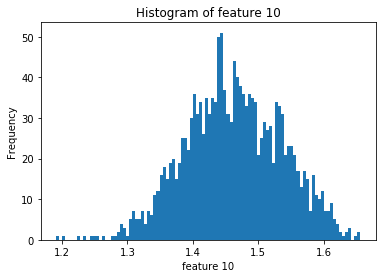

In [15]:
# draw histogram of some features, for example feature 10
plt.hist(secom_origin_df.iloc[:,10], bins = 100)
plt.xlabel('feature 10')
plt.ylabel('Frequency')
plt.title('Histogram of feature 10')
plt.show()

## Step 3: Split datasets 

#### Perform stratified-shuffle splut in order to maintain the pass to fail ratio of the chipsets in the train and test datasets with respect to the original dataset.

In [16]:
# calculate the proportion of failure and pass cases in secom origin dataset. 
# The splited train and test dataset should have the same proportion as here.
secom_origin_df["Result"].value_counts()/len(secom_origin_df)

-1    0.933631
 1    0.066369
Name: Result, dtype: float64

In [17]:
# train and test data proportion is 80% and 20%.
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)

# to have the same proportion regards the "Result", avoiding all the failure in training dataset or test dataset
for train_index, test_index in split.split(secom_origin_df, secom_origin_df["Result"]):
    strat_train_set = secom_origin_df.loc[train_index]
    strat_test_set = secom_origin_df.loc[test_index]

# print out the results of the exact number of train and test datasets correspondingly    
print(len(strat_train_set), "train +", len(strat_test_set), "test")

1253 train + 314 test


In [18]:
# Before any processing of data, create a copy to the origin secom strat_train data set. 
secom_train_set = strat_train_set.copy()
# The same procedure to the test set.
secom_test_set = strat_test_set.copy()

# Separate target from predictors. X is the input set of the data, Y is the label set of the data. 
# We remove "Datetime" variable which we don't need. 
X_train = secom_train_set.drop(["Result", "Datetime"], axis=1)
y_train = secom_train_set["Result"].copy()

# We do the same to the test dataset.
X_test = secom_test_set.drop(["Result", "Datetime"], axis=1)
y_test = secom_test_set["Result"].copy()

In [19]:
# check the propotion of failure and pass in train dataset almost the same to the original whole dataset
secom_train_set["Result"].value_counts()/len(secom_train_set)

-1    0.933759
 1    0.066241
Name: Result, dtype: float64

In [20]:
# check the propotion of failure and pass in test dataset almost the same to the original whole dataset
secom_test_set["Result"].value_counts()/len(secom_test_set)

-1    0.933121
 1    0.066879
Name: Result, dtype: float64

## Step 4 : Pre-processing Data  
Data preprocessing includes 4.1- 4.2 Data Cleaning, 4.3 Outlier replacement, 4.4 Missing value imputation, 4.5 Feature selection, 4.6 Imbalanced datasets, 4.7 Scaling or standardization.

### 4.1: Dealing with missing values part I deletion (the result is to reduce features)
We set a threshold of 55%. Over this value the features will be removed.
The rest of missing values will be imputated with different methods. 

In [21]:
# copy the train dataset before we do any modification of it. 
X_train_na = X_train.copy()
X_test_na = X_test.copy()

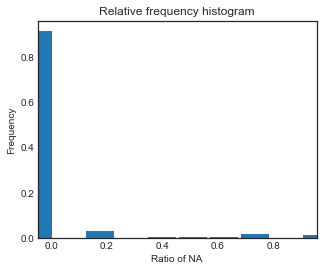

In [22]:
# draw the frequency distribution of the NA proportion in Secom train dataset
# create a empty numpy variable
na_ratio = np.empty(X_train_na.shape[1])
# calcuate the ratio of NA in each column
for i in range(X_train_na.shape[1]):
    na_ratio[i] = X_train_na.iloc[:,i].isnull().sum()/len(X_train_na)  

# use matplotlib to plot the diagram. scipy for relative frequency
%matplotlib inline

plt.style.use('seaborn-white')

na_ratio_rel = stats.relfreq(na_ratio)   
# relative frequencies should add up to 1
np.sum(na_ratio_rel.frequency)  
# Calculate space of values for x
x = na_ratio_rel.lowerlimit + np.linspace(0, na_ratio_rel.binsize*na_ratio_rel.frequency.size,na_ratio_rel.frequency.size)
# Plot relative frequency histogram
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, na_ratio_rel.frequency, width=na_ratio_rel.binsize)
ax.set_title('Relative frequency histogram')
ax.set_xlim([x.min(), x.max()])
#plt.hist(na_ratio)
ax.set_xlabel('Ratio of NA')
ax.set_ylabel('Frequency')
plt.show()

E:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


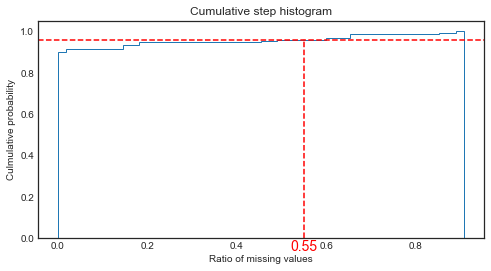

In [23]:
from matplotlib import mlab

x = na_ratio
n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Empirical')
ax.set_title('Cumulative step histogram')
ax.set_xlabel('Ratio of missing values')
ax.set_ylabel('Culmulative probability')

# Draw a vertical line at x=0.55
plt.plot([0.55,0.55],[0,0.96],'r--')
plt.text(0.52,-0.06,'0.55',fontsize=14, color="r")
# draw a horizontal line at y=0.958
plt.axhline(y = 0.958, color="r", linestyle= "--")
plt.show()

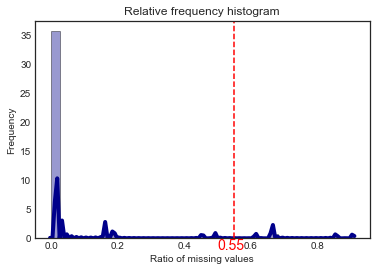

In [24]:
# Density Plot and Histogram of ratio of missing values
ax = sns.distplot(na_ratio, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set(xlabel='Ratio of missing values', ylabel='Frequency')
ax.set_title('Relative frequency histogram')

# add a vertical red line x= 0.55
plt.axvline(x=0.55, color='red', linestyle= '--')
plt.text(0.5,-2,'0.55',fontsize=14, color="r")
plt.show()

In [25]:
# Implement function remova_na on training and test dataset 
delete_na(X_train_na)
delete_na(X_test_na)

In [26]:
# check the dimension of training dataset after deletion of variables over 55% NA
X_train_na.shape

(1253, 566)

In [27]:
# check the dimension of test dataset after deletion of variables over 55% NA
X_test_na.shape

(314, 562)

###  4.2 : Delete the features with very low variance. 
Instead of deleting features with the same values, we define a threshold for standard deviation of features. After this step we successfully delete some features. 

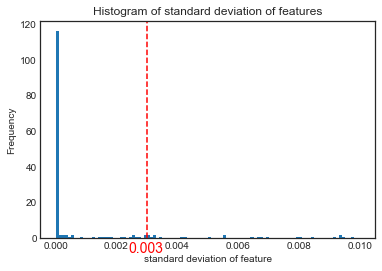

In [28]:
# define a list of standard deviation of training data
X_std = X_train_na.std() 

# the max of standard deviation is 6462.15
#X_std.max()

plt.hist(X_std, bins = 100, range =[X_std.min(),0.01])
plt.xlabel('standard deviation of feature')
plt.ylabel('Frequency')
plt.title('Histogram of standard deviation of features')

# add a vertical red threshold line x= 0.003
plt.axvline(x=0.003, color='red', linestyle='--')
plt.text(0.0024,-8,'0.003',fontsize=14, color="r")
plt.show()

In [29]:
# descriptive statistics of x_std
X_std.describe()

count     566.000000
mean       60.102185
std       393.076426
min         0.000000
25%         0.003008
50%         0.175200
75%         6.646880
max      6464.728110
dtype: float64

In [30]:
## use the defined function remove_std on both training and test dataset to remove the features with very lower std.
remove_std(X_train_na)
remove_std(X_test_na)

In [31]:
X_train_na.shape   # dimension of the training dataset

(1253, 425)

In [32]:
X_test_na.shape   # dimension of the test dataset

(314, 408)

### 4.3 : Outliers replacement
We recognized some outliers in data understanding phase. Now we replace outliers using 3S rules with NaN. 

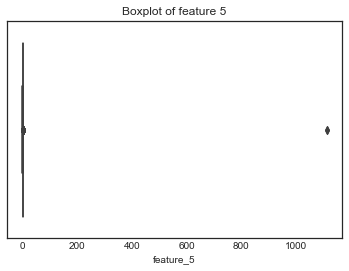

In [33]:
# Discover outlier using visualization tools like boxplot, for example one extreme outlier in feature 5 
sns.boxplot(x= X_train_na.iloc[:,4])   # boxplot diagram of feature 5
plt.title('Boxplot of feature 5')
plt.show()

In [34]:
# compute Zscore for training and test datasets

X_train_zscore = z_score(X_train_na) 
X_test_zscore = z_score(X_test_na)

In [35]:
# show the first 5 rows of dataset after zscore 
X_train_zscore.head()

,feature_1_zscore,feature_2_zscore,feature_3_zscore,feature_4_zscore,feature_5_zscore,feature_7_zscore,feature_8_zscore,feature_9_zscore,feature_10_zscore,feature_11_zscore,...,feature_576_zscore,feature_577_zscore,feature_578_zscore,feature_583_zscore,feature_584_zscore,feature_585_zscore,feature_586_zscore,feature_587_zscore,feature_588_zscore,feature_590_zscore
1198,0.837162,-0.069206,-0.511365,-0.432685,-0.052540,0.740973,-0.147896,-0.870329,-0.924795,-0.078624,...,-0.178097,-0.262093,0.031325,-0.753157,-0.139744,-0.140104,-0.131432,0.051297,-0.693406,-0.551666
436,0.785930,-0.089188,0.585261,0.087234,-0.030636,0.806364,-0.248165,0.850026,0.508637,-1.347349,...,-0.223822,-0.247292,-0.433732,0.116966,0.847867,0.658646,0.811639,0.899082,-1.281979,-0.878099
635,0.045517,0.343180,0.031100,-1.177142,-0.038347,0.853345,-0.110295,-1.252931,0.039634,0.544987,...,0.015472,-0.240885,0.061823,-0.057058,-0.302595,-0.309536,-0.289518,0.891084,0.836883,-0.288967
996,-1.542293,0.909679,0.806855,0.830417,-0.025277,-0.720916,0.265712,1.772614,-1.004063,0.641754,...,-0.234491,-0.229964,-0.269297,0.116966,0.101906,-0.115900,0.095514,-0.132656,0.483739,0.043814
782,-0.433113,-0.371564,-2.805036,-1.144961,-0.037938,0.844760,0.416115,-0.305922,-0.561482,0.050399,...,-0.214677,-0.254297,-0.177479,-0.405108,0.091399,-0.019081,0.090221,1.250992,-0.999464,-0.830954


In [36]:
# Assigning imputed dataframe to new variable for train and test dataframes.
X_train_o = outlier_impute(X_train_zscore)

X_test_o = outlier_impute(X_test_zscore)

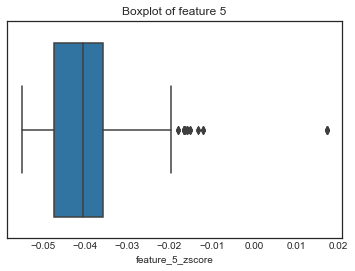

In [37]:
# check again the boxplot diagram of feature 5 which we can see the extreme outlier is replaced with nan.
sns.boxplot(x= X_train_o.iloc[:,4])   # boxplot diagram of feature 5
plt.title('Boxplot of feature 5')
plt.show()

### 4.4 : Missing values part II imputation
We implemented two approaches. One is to replace with mean. The second is to replace with KNN. In the second presentation we compared with two methods and came to conclusion that the final accuracy of the model is not effected. 

#### 4.4 - (1) Simple approach to impute missing values with mean

In [38]:
# Assiging the imputed dataframes to new variables to perform mean imputation.
X_train_mean_in = X_train_o.copy()
X_test_mean_in = X_test_o.copy()

In [39]:
# implement function on training and test dataset
X_train_mean_out = na_mean_imputer(X_train_mean_in)  
X_test_mean_out = na_mean_imputer(X_test_mean_in)

In [40]:
# Dataset after imputation
X_train_mean_out.shape

(1253, 425)

### 4.5: Feature selection 
After data preprocessing listed above, we still have 425 features in training dataset. Feature selection enables to choose the most important features and avoid redudant and noise in the input. 

In the second presentation we compared 3 different methods, namely, Boruta, PCA, Chi2. We compared the results and finally decided to continue with Boruta solution. 

###### Boruta algorithm 

In [41]:
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X_train_b = X_train_mean_out.values
y_train_b = y_train.values
y_train_b = y_train_b.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train_b, y_train_b)

# call transform() on X to filter it down to selected features
X_train_boruta_tf = feat_selector.transform(X_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	425
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	408
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	408
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	408
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	408
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	14
Rejected: 	408
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	14
Rejected: 	408
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	14
Rejected: 	408
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	14
Rejected: 	408
Iteration: 	16 / 100
Confirmed: 	3
Tentat

In [42]:
# Make a list and count the selected features
selected_feat= X_train_mean_out.columns[(feat_selector.support_)]
len(selected_feat)

12

In [43]:
# Return the name of selected features
print(selected_feat)

Index(['feature_32_zscore', 'feature_34_zscore', 'feature_60_zscore',
       'feature_66_zscore', 'feature_104_zscore', 'feature_131_zscore',
       'feature_206_zscore', 'feature_214_zscore', 'feature_248_zscore',
       'feature_352_zscore', 'feature_478_zscore', 'feature_520_zscore'],
      dtype='object')


In [44]:
# create a dataframe with selected features 
X_train_boruta = pd.DataFrame(X_train_mean_out, columns = selected_feat)

In [45]:
# an overview of descriptive statistics of selected features
X_train_boruta.describe()

,feature_32_zscore,feature_34_zscore,feature_60_zscore,feature_66_zscore,feature_104_zscore,feature_131_zscore,feature_206_zscore,feature_214_zscore,feature_248_zscore,feature_352_zscore,feature_478_zscore,feature_520_zscore
count,1.253000e+03,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,1.348341e-14,-0.092869,-0.024442,-0.043423,-0.009633,0.009390,-0.059443,-0.046077,-0.093964,-0.048325,-0.059536,-0.098069
std,1.000000e+00,0.315323,0.823507,0.810029,0.942150,0.978451,0.278781,0.654090,0.547076,0.667928,0.208913,0.497247
min,-2.995172e+00,-1.037885,-2.255645,-2.604832,-2.900349,-2.908103,-0.520935,-1.295231,-0.810312,-1.301147,-0.403827,-0.743595
25%,-5.714482e-01,-0.286757,-0.493693,-0.581673,-0.669944,-0.660163,-0.244259,-0.521537,-0.429120,-0.537668,-0.198923,-0.401482
50%,-4.412373e-01,-0.140653,-0.215812,-0.113992,-0.104020,0.171119,-0.113964,-0.072371,-0.093964,-0.077490,-0.099838,-0.098069
75%,-2.577413e-01,0.068890,0.125317,0.389305,0.528483,0.841662,0.054937,0.318003,-0.093964,0.325167,0.024667,-0.098069
max,2.135588e+00,1.546000,2.689102,2.999985,2.825467,1.735320,2.051990,2.937745,2.971352,2.756794,1.495759,2.791656


In [46]:
# for the test dataset to have the same selected features from training dataset
X_test_boruta = pd.DataFrame(X_test_mean_out, columns= selected_feat)
X_test_boruta.shape

(314, 12)

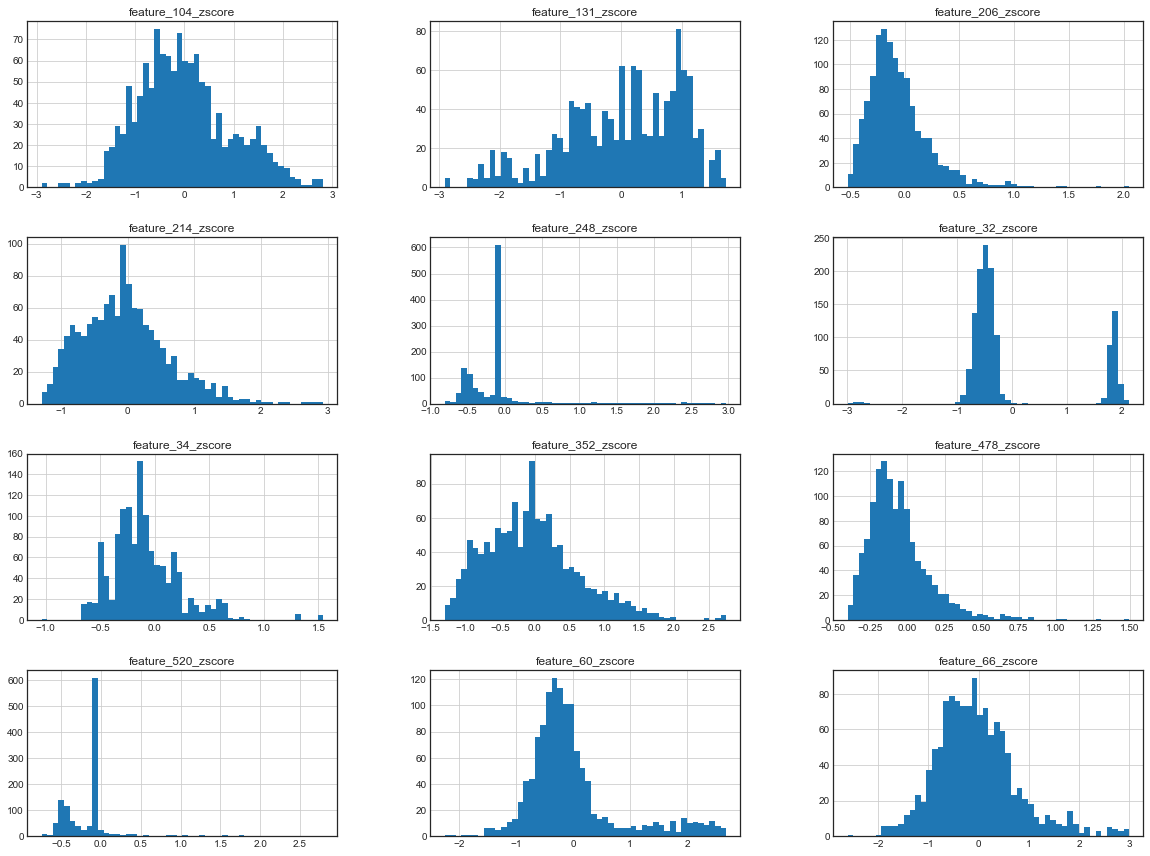

In [47]:
# histogram of remaining features
X_train_boruta.hist(bins=50, figsize=(20,15))
plt.show()

### 4.6 Dealing with imbalanced dataset

Secom dataset is imbalanced. We have only fewer failure cases compared to pass cases. In order to get better detection of the failure cases the oversampling method is required. We compared two approaches here: SMOTE and ADASYN.

Method 1: SMOTE Oversampling

In [48]:
print("Before oversampling, count of label '-1':{}".format(sum(y_train == -1)))
print("Before oversampling, count of label '-1':{} \n".format(sum(y_train == 1)))

sm = SMOTE(random_state=2)

X_train_smote, y_train_smote = sm.fit_sample(X_train_boruta, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

print("After oversampling, count of label '-1':{}".format(sum(y_train_smote == -1)))
print("After oversampling, count of label '1':{} \n".format(sum(y_train_smote == 1)))

Before oversampling, count of label '-1':1170
Before oversampling, count of label '-1':83 

After OverSampling, the shape of train_X: (2340, 12)
After OverSampling, the shape of train_y: (2340,) 

After oversampling, count of label '-1':1170
After oversampling, count of label '1':1170 



Method 2: ADASYN Oversampling

In [49]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train_boruta, y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_adasyn.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_adasyn.shape))

print("After oversampling, count of label '-1':{}".format(sum(y_train_adasyn == -1)))
print("After oversampling, count of label '1':{} \n".format(sum(y_train_adasyn == 1)))

After OverSampling, the shape of train_X: (2351, 12)
After OverSampling, the shape of train_y: (2351,) 

After oversampling, count of label '-1':1170
After oversampling, count of label '1':1181 



###### Visualize the data before and after oversampling.

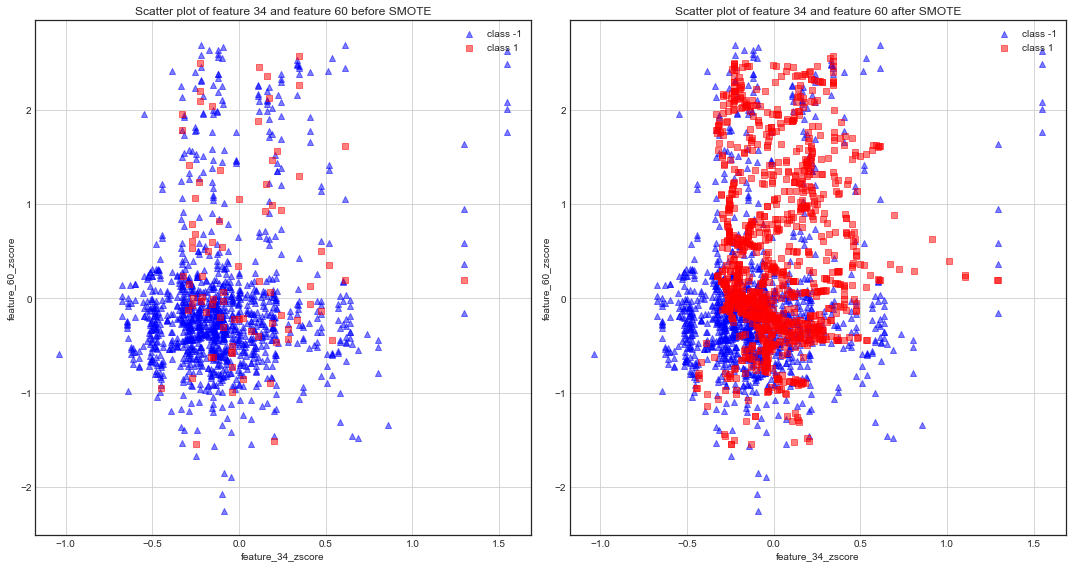

In [50]:
# plot two subgraphs in one row.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

# l is the class either -1 or 1. m is the type of the points.

# Before SMOTE
for l, c, m in zip((-1,1), ('blue', 'red'), ('^', 's')):
    ax1.scatter(X_train_boruta_tf[y_train == l,1],
                X_train_boruta_tf[y_train == l,2],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )
# After SMOTE  
for l, c, m in zip((-1, 1), ('blue', 'red'), ('^', 's')):
    ax2.scatter(X_train_smote[y_train_smote == l,1],    
                X_train_smote[y_train_smote == l,2],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Scatter plot of feature 34 and feature 60 before SMOTE')
ax2.set_title('Scatter plot of feature 34 and feature 60 after SMOTE')

for ax in (ax1, ax2):
    ax.set_xlabel(X_train_boruta.columns[1])
    ax.set_ylabel(X_train_boruta.columns[2])
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

### 4.6 : Data normalization or Data scaling
Some models like KNN and SVM are very sensitive to the input data, requiring data scaling. While some models like Random Forest and Naive Bayes are very robust and invariant to feature scaling.

Two method are defined below, one is data standardization, the other is MinMax scaling. Even though we did standardization at the beginning of data preprocessing. After imputation of missing values the dataset is no more standardized because it introduce new datas to the dataset.

Method I : Standardization to have mean=0, std=1

In [53]:
# standardize the dataset to have a mean= 0 and std=1
sc = StandardScaler()

# standardize the training dataset AFTER boruta feature selection
X_train_mean_std = sc.fit_transform(X_train_smote)

# standardize the training dataset for KNN imputed
#X_train_knn_std = sc.fit_transform(x_train_knn_out)

# standardize the test dataset for mean imputed
X_test_mean_std = sc.fit_transform(X_test_boruta)

# standardize the test dataset for KNN imputed
#X_test_knn_std = sc.fit_transform(x_test_knn_out)

# Convert the numpy array back to the panda dataframe
X_train_mean_std_df= pd.DataFrame(X_train_mean_std, columns = selected_feat)
X_test_mean_std_df = pd.DataFrame(X_test_mean_std, columns = selected_feat)



Method II: MinMax scaling to [0,1]

In [54]:
# scale the imputed data to the range [0, 1], which is the default range.
from sklearn.preprocessing import MinMaxScaler
Mmsc = MinMaxScaler()

# Scale mean imputed values
X_train_mean_MinMax = Mmsc.fit_transform(X_train_smote)
X_test_mean_MinMax = Mmsc.fit_transform(X_test_boruta)

# Scale KNN imputed values
#x_train_knn_MinMax = Mmsc.fit_transform(x_train_knn_out)
#x_test_knn_MinMax = Mmsc.fit_transform(x_test_knn_out)

In [52]:
# Convert the numpy array back to the panda dataframe
X_train_mean_MinMax_df = pd.DataFrame(X_train_mean_MinMax, columns = selected_feat)
X_test_mean_MinMax_df = pd.DataFrame(X_test_mean_MinMax, columns = selected_feat)

## Step 5: Build models on the training dataset and evaluate on the test dataset
We build the following models on the training datasets: 1. Logistic Regression, 2. Random Forest. 3.SVM, 4. Naive Bayes. 5. Adaboost 6. Voting classifer


#### Model 1 Logistic Regression Without dealing with Imbalanced dataset
We build logistic Regression using training data before implementing SMOTE. So the training dataset is imbalanced.

In [55]:
# Model 1: Logistic Regression without SMOTE implementation
lr_be = LogisticRegression(penalty='l1',C=1.0, random_state=0).fit(X_train_boruta, y_train)   # use Boruta algorithm feature selection 

print('train accuracy: %f' % lr_be.score(X_train_boruta,y_train))

train accuracy: 0.933759


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [56]:
# making predictions on the testing set 
y_pred_lr_be = lr_be.predict(X_test_boruta)
print('false classification: %d' %(y_test != y_pred_lr_be).sum())
print('test accuracy: %f' % lr_be.score(X_test_boruta ,y_test))

# calculate the confusion matrix
cnf_matrix_lr_be = confusion_matrix(y_test, y_pred_lr_be)

# Calculate F1 score
print('F1 score of test dataset: %f' % f1_score(y_test, y_pred_lr_be))
print('Recall score of test dataset: %f' % recall_score(y_test, y_pred_lr_be))
cnf_matrix_lr_be

false classification: 21
test accuracy: 0.933121
F1 score of test dataset: 0.086957
Recall score of test dataset: 0.047619


array([[292,   1],
       [ 20,   1]], dtype=int64)

In [57]:
print(classification_report(y_test, y_pred_lr_be, target_names = ['class -1', 'class 1']))

              precision    recall  f1-score   support

    class -1       0.94      1.00      0.97       293
     class 1       0.50      0.05      0.09        21

    accuracy                           0.93       314
   macro avg       0.72      0.52      0.53       314
weighted avg       0.91      0.93      0.91       314



This model is useless because it can not detect the fault wafer. The reason is due to the imblanced data. The model has preference to predict the majority class. 

#### Model 1: Logistic Regression with Balanced training data
Without oversampling technique the logistic model has through high accuracy but it can not classify the minor class. So it is necessary to feed the model with the balanced data.

Here we can compare the results with two oversampling techniques: SMOTE and ADASYN.

In [58]:
# Using Gridsearch to find the best parameter // Tuning the hyper-parameters of an estimator
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_smote, y_train_smote.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done  34 out of  50 | elapsed:    4.5s remaining:    2.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.7s finished
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [59]:
clf.best_params_

{'C': 10.0}

In [60]:
# Logistic Regression with SMOTE implementation
lr_smote = LogisticRegression(C=10,penalty='l2', verbose=0)
lr_smote.fit(X_train_smote, y_train_smote.ravel())

# Logistic Regression with ADASYN implementation
lr_ada = LogisticRegression(C=1,penalty='l2', verbose=0)
lr_ada.fit(X_train_smote, y_train_smote.ravel())

print('train accuracy after smote: %f' %lr_smote.score(X_train_smote,y_train_smote))
print('train accuracy after adasyn: %f' %lr_ada.score(X_train_adasyn,y_train_adasyn))

train accuracy after smote: 0.667094
train accuracy after adasyn: 0.655466


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [61]:
# Assess the model on test datasets

# making predictions on the testing set 
y_pred_lr_smote_test = lr_smote.predict(X_test_boruta)      # on the smote test dataset
y_pred_lr_ada_test = lr_ada.predict(X_test_boruta)      # on the adasyn test dataset

print('false classification after smote: %d' %(y_test != y_pred_lr_smote_test).sum() +
      '  false classification after adasyn: %d' %(y_test != y_pred_lr_ada_test).sum())
print('test accuracy after smote: %f' % lr_smote.score(X_test_boruta ,y_test) + 
     '  test accuracy after adasyn: %f' % lr_ada.score(X_test_boruta ,y_test))
print('F1 score of test dataset after smote: %f' %f1_score(y_test,y_pred_lr_smote_test))
print('Recall score of test dataset after smote: %f' % recall_score(y_test,y_pred_lr_smote_test))

false classification after smote: 105  false classification after adasyn: 83
test accuracy after smote: 0.665605  test accuracy after adasyn: 0.735669
F1 score of test dataset after smote: 0.173228
Recall score of test dataset after smote: 0.523810


In [62]:
# confusion matrix after smote
cnf_matrix_lr_smote_test = confusion_matrix(y_test, y_pred_lr_smote_test)
# confusion matrix after adasyn
cnf_matrix_lr_ada_test = confusion_matrix(y_test, y_pred_lr_ada_test)

print(cnf_matrix_lr_smote_test)
print(cnf_matrix_lr_ada_test)

[[198  95]
 [ 10  11]]
[[219  74]
 [  9  12]]


### Model 2 : Random forest with balanced data input
We compare also the model with training data after SMOTE and Adasyn. SMOTE has given better results shown in the test accuracy.

In [63]:
from sklearn.ensemble import RandomForestClassifier
#use the GridSearch to automatically find the best parameters. 
param_grid_rnd = {'n_estimators':[400,500], 'max_leaf_nodes':[16,18]}

# use random forest classifier
rnd_clf = RandomForestClassifier()

grid_search_rnd = GridSearchCV(rnd_clf, param_grid_rnd, cv = 5)
grid_search_rnd.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [65]:
grid_search_rnd.best_params_

{'max_leaf_nodes': 18, 'n_estimators': 500}

In [66]:
# Random forest after Smote
rf_clf_smote = RandomForestClassifier(max_leaf_nodes= 18, n_estimators= 500)
rf_clf_smote.fit(X_train_smote,y_train_smote)

#Random forest after Adasyn
rf_clf_ada = RandomForestClassifier(max_leaf_nodes= 18, n_estimators= 500)
rf_clf_ada.fit(X_train_adasyn, y_train_adasyn)

print('train accuracy after smote: %f' % rf_clf_smote.score(X_train_smote,y_train_smote))
print('train accuracy after adasyn: %f' % rf_clf_ada.score(X_train_adasyn, y_train_adasyn))

train accuracy after smote: 0.878632
train accuracy after adasyn: 0.872395


In [67]:
# Test on the test dataset
y_pred_rf_test_smote = rf_clf_smote.predict(X_test_boruta)   # The model trained by input data after smote 

y_pred_rf_test_ada = rf_clf_ada.predict(X_test_boruta)   # The model trained by input data after adasyn

print('false classification after smote: %d' %(y_test != y_pred_rf_test_smote).sum())
print('false classification after adasyn: %d' %(y_test != y_pred_rf_test_ada).sum())
print('test accuracy after smote: %f' % rf_clf_smote.score(X_test_boruta ,y_test))
print('test accuracy after adasyn: %f' % rf_clf_ada.score(X_test_boruta ,y_test))

print('F1 score of test dataset after smote: %f' % f1_score(y_test, y_pred_rf_test_smote))
print('Recall score of test dataset after smote: %f' % recall_score(y_test, y_pred_rf_test_smote))

false classification after smote: 75
false classification after adasyn: 81
test accuracy after smote: 0.761146
test accuracy after adasyn: 0.742038
F1 score of test dataset after smote: 0.257426
Recall score of test dataset after smote: 0.619048


In [68]:
# calculate the confusion matrix
cnf_matrix_rf_smote_test = confusion_matrix(y_test, y_pred_rf_test_smote)
cnf_matrix_rf_smote_test

array([[226,  67],
       [  8,  13]], dtype=int64)

After the comparison of two models implemented with SMOTE and ADASYN, SMOTE performs better and gives higher accuracy and F1 score. We decide to use SMOTE in the following models

#### Model 3 after SMOTE and Adasyn : Support Vector machine (SVM)

In [69]:
from sklearn import svm
svm = svm.SVC(gamma='scale')
# after smote
svm =svm.fit(X_train_smote, y_train_smote)
# after ada
#svm_ada = svm.fit(X_train_adasyn, y_train_adasyn)


print('train accuracy: %f' % svm.score(X_train_smote, y_train_smote))
#print('train accuracy: %f' % svm.score(X_train_adasyn, y_train_adasyn))

train accuracy: 0.878205


In [70]:
y_pred_svm_test = svm.predict(X_test_boruta)

#y_pred_svm_test_ada = svm_ada.predict(X_test_boruta)   # The model trained by input data after adasyn


print('false classification: %d' %(y_test != y_pred_svm_test).sum())
#print('false classification: %d' %(y_test != y_pred_svm_test_ada).sum())

print('test accuracy: %f' % svm.score(X_test_boruta ,y_test))
#print('test accuracy: %f' % svm_ada.score(X_test_boruta ,y_test))

# calculate the confusion matrix
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm_test)

#cnf_matrix_svm_ada = confusion_matrix(y_test, y_pred_svm_test_ada)

# Calculate F1 score
print('F1 score of test dataset: %f' % f1_score(y_test, y_pred_svm_test))
print('Recall score of test dataset: %f' % recall_score(y_test, y_pred_svm_test))

print(cnf_matrix_svm)
#print(cnf_matrix_svm_ada)

false classification: 74
test accuracy: 0.764331
F1 score of test dataset: 0.229167
Recall score of test dataset: 0.523810
[[229  64]
 [ 10  11]]


#### Model 4 after SMOTE: Naive Bayes

In [71]:
gnb = GaussianNB()
gnb.fit(X_train_smote, y_train_smote)

print('train accuracy: %f' % gnb.score(X_train_smote, y_train_smote))

train accuracy: 0.685043


In [72]:
y_pred_gnb_test = gnb.predict(X_test_boruta)

print('false classification: %d' %(y_test != y_pred_gnb_test).sum())
print('test accuracy: %f' % gnb.score(X_test_boruta ,y_test))

# calculate the confusion matrix
cnf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb_test)

# Calculate F1 score
print('F1 score of test dataset: %f' % f1_score(y_test, y_pred_gnb_test))
print('Recall score of test dataset: %f' % recall_score(y_test, y_pred_gnb_test))

cnf_matrix_gnb

false classification: 86
test accuracy: 0.726115
F1 score of test dataset: 0.232143
Recall score of test dataset: 0.619048


array([[215,  78],
       [  8,  13]], dtype=int64)

#### Model 5 after SMOTE: AdaBoost

In [73]:
#use the GridSearch to automatically find the best parameters. 
param_grid_ada_clf = {'n_estimators':[10,25,40],'learning_rate' :[0.1,0.5]}

# use random forest classifier
ada_clf = AdaBoostClassifier()

grid_search_ada_clf = GridSearchCV(ada_clf, param_grid_ada_clf, cv = 5)
grid_search_ada_clf.fit(X_train_smote, y_train_smote)

#ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators =25, 
#                            algorithm = 'SAMME.R', learning_rate=0.5)
#ada_clf.fit(X_train_smote, y_train_smote)

#print('train accuracy: %f' % ada_clf.score(X_train_smote, y_train_smote))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.5],
                         'n_estimators': [10, 25, 40]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
grid_search_ada_clf.best_params_

{'learning_rate': 0.5, 'n_estimators': 40}

In [75]:
# however I changed back to 25 estimators realizing the model is overfitting and we get higher error on test set.
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators =25,  
                             algorithm = 'SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train_smote, y_train_smote)
print('train accuracy: %f' % ada_clf.score(X_train_smote, y_train_smote))


train accuracy: 0.815812


In [76]:
y_pred_ada_test = ada_clf.predict(X_test_boruta)

print('false classification: %d' %(y_test != y_pred_ada_test).sum())
print('test accuracy: %f' % ada_clf.score(X_test_boruta ,y_test))

# calculate the confusion matrix
cnf_matrix_ada = confusion_matrix(y_test, y_pred_ada_test)

# Calculate F1 score
print('F1 score of test dataset: %f' % f1_score(y_test, y_pred_ada_test))
print('Recall score of test dataset: %f' % recall_score(y_test, y_pred_ada_test))

cnf_matrix_ada

false classification: 94
test accuracy: 0.700637
F1 score of test dataset: 0.253968
Recall score of test dataset: 0.761905


array([[204,  89],
       [  5,  16]], dtype=int64)

#### Model 6: VOTING Classifier
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

In [77]:
voting_clf = VotingClassifier(estimators=[('rf',rf_clf_smote),('gnb',gnb),('ada',ada_clf)], voting = 'soft')
voting_clf.fit(X_train_smote, y_train_smote)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=18,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=500,
                                                     n_jobs=None,
            

In [78]:
# compare the accurracy score for each classifier model
for clf in (rf_clf_smote, gnb, ada_clf, voting_clf):
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test_boruta)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    #print(clf.__class__.__name__, recall_score(y_test, y_pred))

RandomForestClassifier 0.767515923566879
GaussianNB 0.7261146496815286
AdaBoostClassifier 0.7006369426751592
VotingClassifier 0.7643312101910829


In [79]:
y_pred_voting = voting_clf.predict(X_test_boruta)
cnf_matrix_voting = confusion_matrix(y_test, y_pred_voting)
cnf_matrix_voting

array([[226,  67],
       [  7,  14]], dtype=int64)

## Step 6 : Evaluate the model with Confusion matrix , AUC, Accuracy, Recall

##### 6.1 Confusion matrix

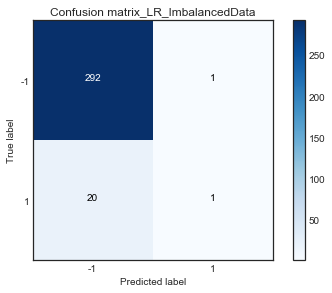

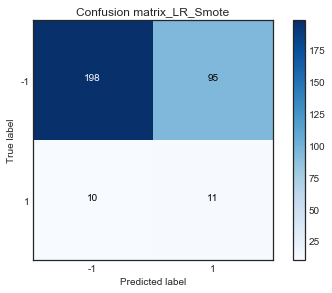

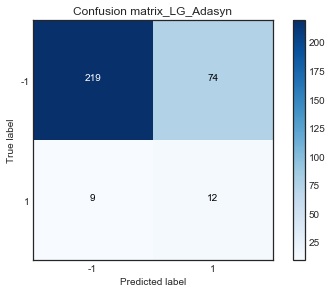

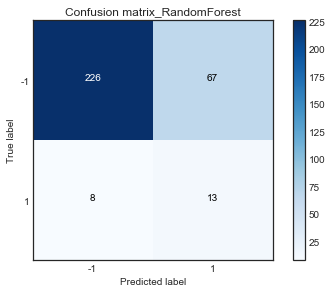

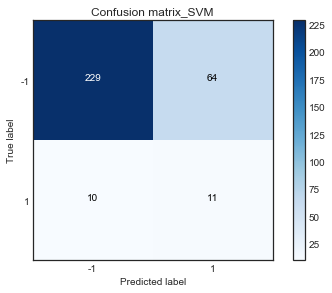

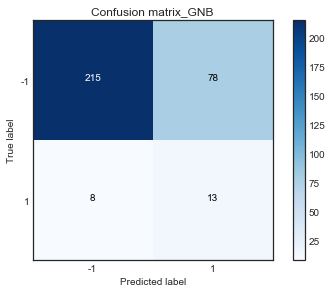

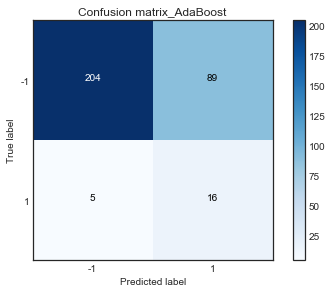

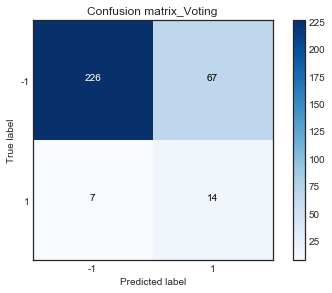

In [80]:
class_names = [-1,1]   #y label

plt.figure()
# a list of confusion matrix to be drawn
cnf_matrix = [cnf_matrix_lr_be,cnf_matrix_lr_smote_test, cnf_matrix_lr_ada_test,cnf_matrix_rf_smote_test,cnf_matrix_svm,cnf_matrix_gnb,cnf_matrix_ada,cnf_matrix_voting]
# create title lists correspondingly 
title1 = ['Confusion matrix_LR_ImbalancedData','Confusion matrix_LR_Smote','Confusion matrix_LG_Adasyn','Confusion matrix_RandomForest','Confusion matrix_SVM','Confusion matrix_GNB','Confusion matrix_AdaBoost',
         'Confusion matrix_Voting']

# use for loop to plot 
for i,title in zip(cnf_matrix,title1): 
    plot_confusion_matrix(i , classes=class_names, title= title)
    plt.show()

#### 6.2 Comparison of Roc curve and AUC

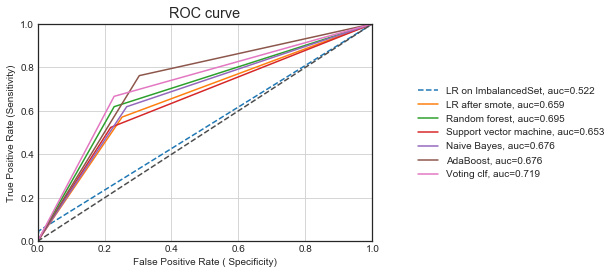

In [81]:
# Plot Roc_curve for each model and caculate the area under the curve using auc.
# Logistic regression with original imbalanced dataset
fpr_lr_be, tpr_lr_be, thresholds = roc_curve(y_test, y_pred_lr_be)
auc_lr_be = round(auc(fpr_lr_be, tpr_lr_be),3)  


#Logistic Regression 
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_lr_ada_test)
auc_lr = round(auc(fpr_lr, tpr_lr),3)  

# Random forest
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_rf_test_smote)
auc_rf = round(auc(fpr_rf, tpr_rf),3)  

# Support Vector Machine
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, y_pred_svm_test)
auc_svm = round(auc(fpr_svm, tpr_svm),3)

# Naive Bayes
fpr_gnb, tpr_gnb, thresholds = roc_curve(y_test, y_pred_gnb_test)  
auc_gnb = round(auc(fpr_gnb, tpr_gnb),3)

# AdaBoost
fpr_ada, tpr_ada, thresholds = roc_curve(y_test, y_pred_ada_test)  
auc_ada = round(auc(fpr_ada, tpr_ada),3)

# Voting classifier
fpr_voting, tpr_voting, thresholds = roc_curve(y_test, y_pred_voting)
auc_voting = round(auc(fpr_voting, tpr_voting),3)     # round it to only 3 decimal points


# Plot the graph
fig, ax = plt.subplots()
ax.plot(fpr_lr_be, tpr_lr_be, label= "LR on ImbalancedSet, auc="+str(auc_lr_be),linestyle= "--" )
ax.plot(fpr_lr, tpr_lr, label= "LR after smote, auc="+str(auc_lr))
ax.plot(fpr_rf, tpr_rf, label= "Random forest, auc="+str(auc_rf))
ax.plot(fpr_svm, tpr_svm, label= "Support vector machine, auc="+str(auc_svm))
ax.plot(fpr_gnb, tpr_gnb, label= "Naive Bayes, auc="+str(auc_gnb))
ax.plot(fpr_ada, tpr_ada, label= "AdaBoost, auc="+str(auc_gnb))
ax.plot(fpr_voting, tpr_voting, label= "Voting clf, auc="+str(auc_voting))
plt.legend(loc='center right',bbox_to_anchor=(1.72, 0.5))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate ( Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

0.90 - 1.00 = excellent
0.80 - 0.90 = good
0.70 - 0.80 = fair
0.60 - 0.70 = poor
0.50 - 0.60 = fail


#### 6.3 Comparison with accuracy and sensitivity 

In [82]:
# compare the accurracy score for each classifier model
clf_total = [lr_ada, rf_clf_smote, svm, gnb, ada_clf, voting_clf]
clf_best = [rf_clf_smote, gnb, ada_clf, voting_clf]

# Create a dataframe for storing the models scores from the for loop.
scores_df = pd.DataFrame(columns= ['models','accuracy','sensitivity','f1_score'])

for clf, i in zip(clf_total,range(6)):
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test_boruta)
    # store the each score in the list
    
    scores_df.loc[i,['models']] = clf.__class__.__name__
    scores_df.loc[i,['accuracy']] = accuracy_score(y_test, y_pred)
    scores_df.loc[i,['sensitivity']] = recall_score(y_test, y_pred)
    scores_df.loc[i,['f1_score']] = f1_score(y_test, y_pred)
        
    #scores_df.append((clf.__class__.__name__, accuracy_score(y_test, y_pred),recall_score(y_test, y_pred)))
    #print(clf.__class__.__name__, 'accuracy: %f' % accuracy_score(y_test, y_pred))
    #print(clf.__class__.__name__, 'recall: %f' % recall_score(y_test, y_pred))
    #print(clf.__class__.__name__, 'f1: %f' % f1_score(y_test, y_pred))

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [83]:
# summary of the results of different models
scores_df

,models,accuracy,sensitivity,f1_score
0,LogisticRegression,0.735669,0.571429,0.224299
1,RandomForestClassifier,0.770701,0.666667,0.28
2,SVC,0.764331,0.52381,0.229167
3,GaussianNB,0.726115,0.619048,0.232143
4,AdaBoostClassifier,0.700637,0.761905,0.253968
5,VotingClassifier,0.761146,0.666667,0.271845


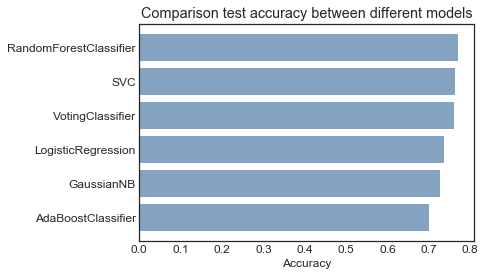

In [84]:
# draw the accuracy with horizontal bars
fig, ax = plt.subplots()

# Sort the scores_df in descending order by accuracy
scores_acc = scores_df.sort_values(by = 'accuracy', ascending = False)

models1 = scores_acc.loc[:,'models']
y_pos = np.arange(len(models1))
#error = np.random.rand(len(models)) #xerr=error,color=(0.2, 0.4, 0.6, 0.6)   color='rgbkymc'

ax.barh(y_pos,scores_acc.loc[:,'accuracy'] ,align = 'center', color=(0.2, 0.4, 0.6, 0.6))
ax.set_yticks(y_pos)
ax.set_yticklabels(models1)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Comparison test accuracy between different models')

plt.show()

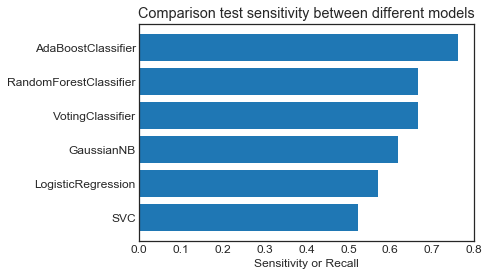

In [85]:
# draw the accuracy with horizontal bars
fig, ax = plt.subplots()

# Sort the scores_df in descending order by sensitivity
scores_sen = scores_df.sort_values(by = 'sensitivity', ascending = False)

models2 = scores_sen.loc[:,'models']
y_pos = np.arange(len(models2))
#error = np.random.rand(len(models)) #xerr=error,

ax.barh(y_pos, scores_sen.loc[:,'sensitivity'] ,align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models2)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sensitivity or Recall')
ax.set_title('Comparison test sensitivity between different models')

plt.show()